# Trading with deep learning

* Deep Learning
* Data
* ???
* Profit !!

In [ ]:
%matplotlib inline
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot

import numpy as np
import tensorflow as tf
import google.datalab.bigquery as bq
import matplotlib.pyplot as plt


def get_data(name):
    table = 'bingo-ml-1.market_data.{}'.format(name)
    fields = ['Date', 'Close']
    data = bq.Query.from_table(bq.Table(table), fields=fields).execute().result().to_dataframe().set_index('Date')
    return data['Close']

closing_data = pd.DataFrame()

# indexes = ['snp', 'nyse', 'djia', 'nikkei', 'hangseng', 'ftse', 'dax', 'aord']
indexes = ['snp', 'nyse', 'djia', 'nikkei', 'hangseng', 'ftse', 'dax', 'aord']

for index in indexes:
    closing_data['{}_close'.format(index)] = get_data(index)

closing_data = closing_data.fillna(method='ffill')

closing_data.describe()

,snp_close,nyse_close,djia_close,nikkei_close,hangseng_close,ftse_close,dax_close,aord_close
count,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000
mean,1549.733275,8920.468489,14017.464990,12562.240032,22250.759871,6097.818589,7959.386910,4910.363302
std,338.278280,1420.830375,2522.948044,3653.294124,2024.991482,552.471781,1761.802671,486.961236
min,1022.580017,6434.810059,9686.480469,8160.009766,16250.269531,4805.799805,5072.330078,3927.600098
25%,1271.239990,7668.234863,11987.635254,9463.864746,20850.485351,5677.849853,6448.355225,4483.199951
50%,1433.189941,8445.769531,13323.360352,10815.030273,22444.800781,6005.100098,7426.810059,4899.200195
75%,1875.510010,10370.324707,16413.575196,15215.709961,23447.339844,6620.699951,9403.629883,5345.750000
max,2130.820068,11239.660156,18312.390625,20868.029297,28442.750000,7104.000000,12374.730469,5954.799805


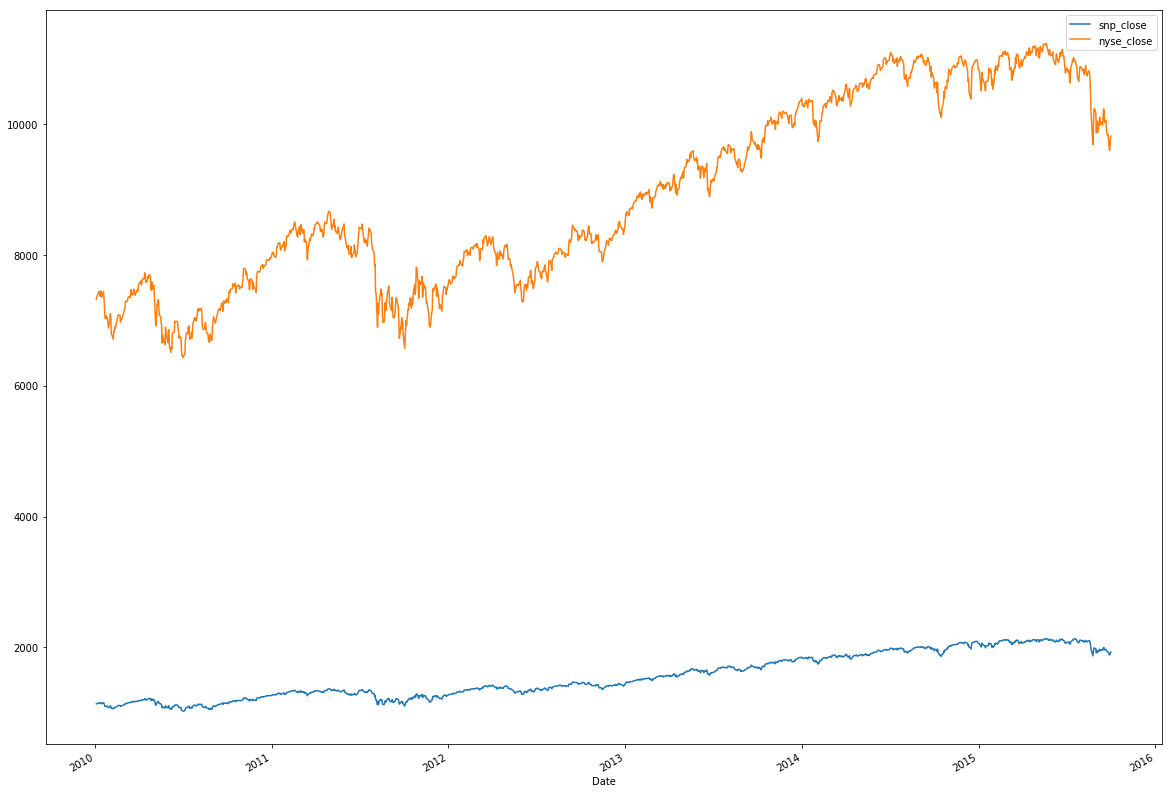

In [3]:
_ = pd.concat([
    closing_data['snp_close'],
    closing_data['nyse_close']
], axis=1).plot(figsize=(20, 15))

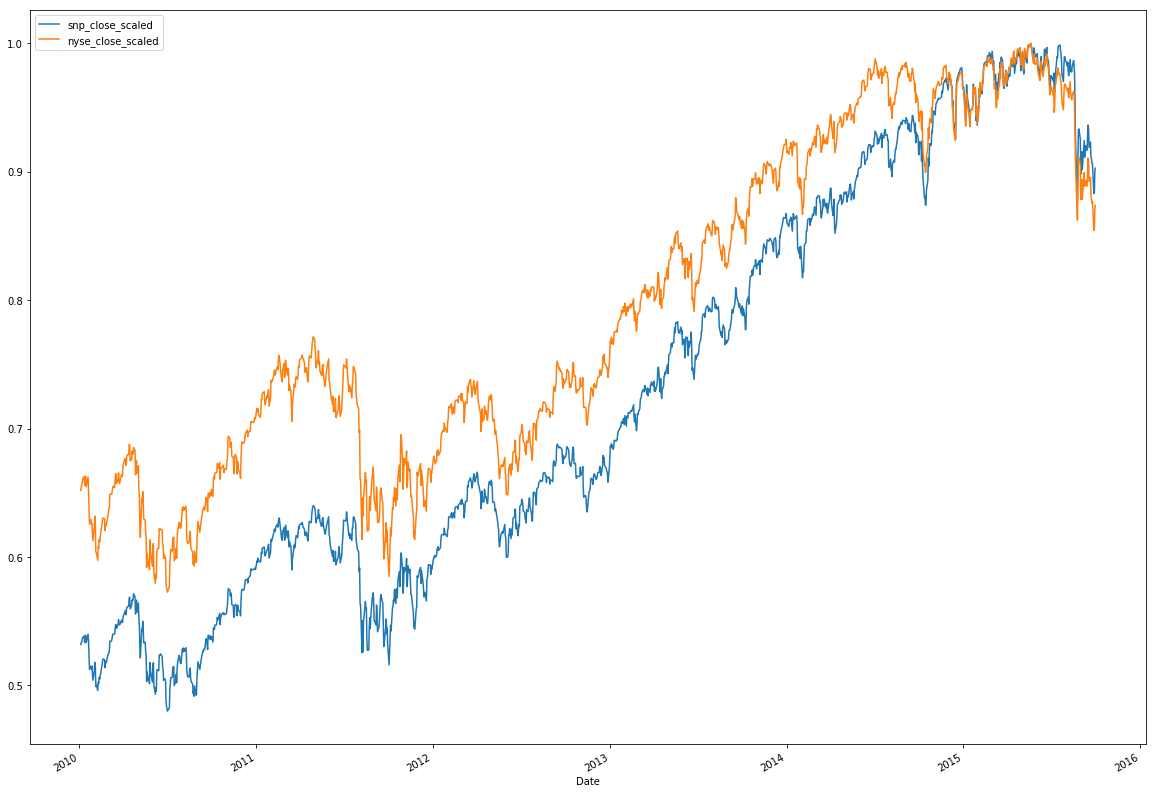

In [2]:
for index in indexes:
    closing_data['{}_close_scaled'.format(index)] = closing_data['{}_close'.format(index)] / max(closing_data['{}_close'.format(index)])

_ = pd.concat([
    closing_data['snp_close_scaled'],
    closing_data['nyse_close_scaled']
], axis=1).plot(figsize=(20, 15))

In [3]:
# Log Return
log_return_data = pd.DataFrame()

for index in indexes:
    log_return_data['{}_log_return'.format(index)] = np.log(
        closing_data['{}_close'.format(index)] / closing_data['{}_close'.format(index)].shift()
    )
    
log_return_data.describe()

,snp_log_return,nyse_log_return,djia_log_return,nikkei_log_return,hangseng_log_return,ftse_log_return,dax_log_return,aord_log_return
count,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000
mean,-0.000388,-0.000309,-0.000344,-0.000337,-0.000068,-0.000212,-0.000330,-0.000135
std,0.283236,0.209795,0.238571,0.342093,0.116175,0.122537,0.273648,0.129086
min,-0.692658,-0.506502,-0.600737,-0.870563,-0.457791,-0.326003,-0.787802,-0.364802
25%,-0.192233,-0.140085,-0.164099,-0.164568,-0.067824,-0.085775,-0.181835,-0.081770
50%,0.001868,0.002654,0.005476,0.000000,0.000000,0.000000,0.004398,0.000000
75%,0.172184,0.141786,0.151943,0.185417,0.074022,0.084336,0.178776,0.086402
max,0.694100,0.504759,0.608545,0.879570,0.356832,0.310955,0.733355,0.351090


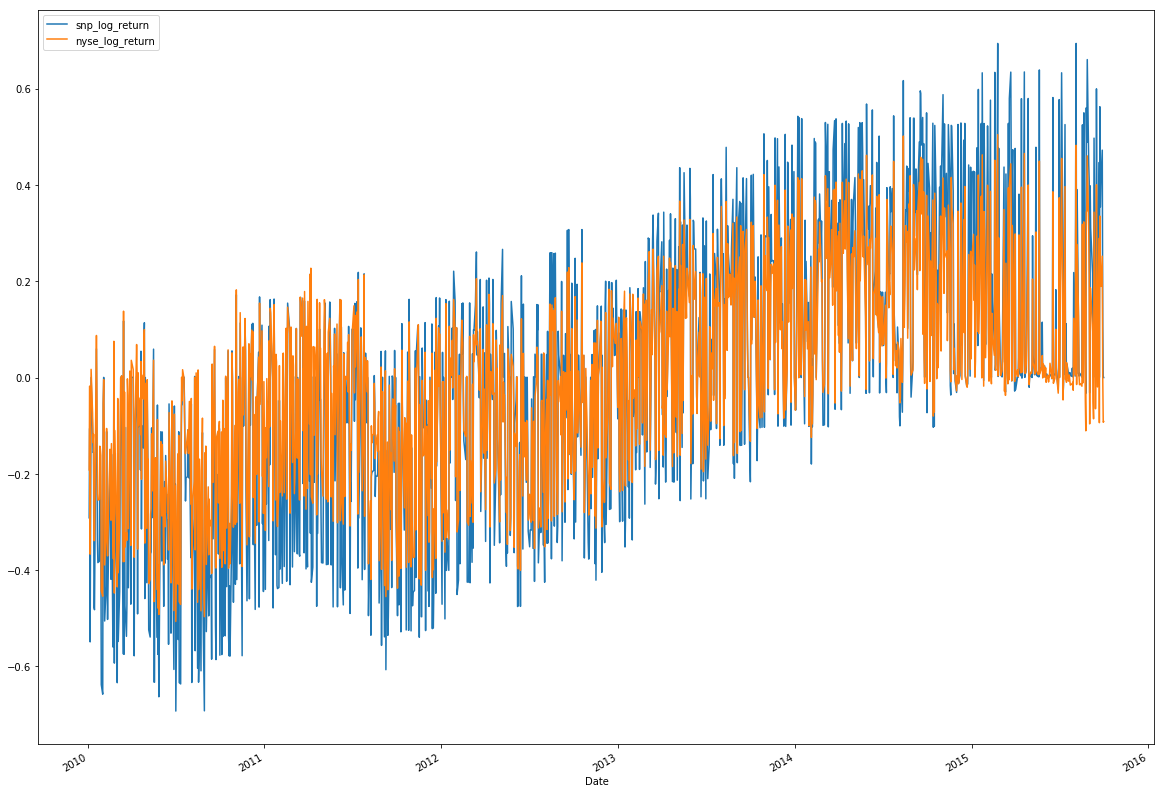

In [4]:
_ = pd.concat([
    log_return_data['snp_log_return'],
    log_return_data['nyse_log_return']
], axis=1).plot(figsize=(20, 15))

In [5]:
log_return_data['snp_log_return_positive'] = 0
log_return_data.loc[log_return_data['snp_log_return'] >= 0, 'snp_log_return_positive'] = 1
log_return_data['snp_log_return_negative'] = 0
log_return_data.loc[log_return_data['snp_log_return'] < 0, 'snp_log_return_negative'] = 1

training_test_data = pd.DataFrame(columns=[
    'snp_log_return_positive', 
    'snp_log_return_negative',
    'snp_log_return_1',
    'snp_log_return_2',
    'snp_log_return_3',
    'nyse_log_return_1',
    'nyse_log_return_2',
    'nyse_log_return_3',
    'djia_log_return_1',
    'djia_log_return_2',
    'djia_log_return_3',
    'nikkei_log_return_0',
    'nikkei_log_return_1',
    'nikkei_log_return_2',
    'hangseng_log_return_0',
    'hangseng_log_return_1',
    'hangseng_log_return_2',
    'ftse_log_return_0',
    'ftse_log_return_1',
    'ftse_log_return_2',
    'dax_log_return_0',
    'dax_log_return_1',
    'dax_log_return_2',
    'aord_log_return_0',
    'aord_log_return_1',
    'aord_log_return_2'
])

for i in range(7, len(log_return_data)):
    training_test_data = training_test_data.append({
        'snp_log_return_positive': log_return_data['snp_log_return_positive'].iloc[i],
        'snp_log_return_negative': log_return_data['snp_log_return_negative'].iloc[i],
        'snp_log_return_1': log_return_data['snp_log_return'].iloc[i-1],
        'snp_log_return_2': log_return_data['snp_log_return'].iloc[i-2],
        'snp_log_return_3': log_return_data['snp_log_return'].iloc[i-3],
        'nyse_log_return_1': log_return_data['nyse_log_return'].iloc[i-1],
        'nyse_log_return_2': log_return_data['nyse_log_return'].iloc[i-2],
        'nyse_log_return_3': log_return_data['nyse_log_return'].iloc[i-3],
        'djia_log_return_1': log_return_data['djia_log_return'].iloc[i-1],
        'djia_log_return_2': log_return_data['djia_log_return'].iloc[i-2],
        'djia_log_return_3': log_return_data['djia_log_return'].iloc[i-3],
        'nikkei_log_return_0': log_return_data['nikkei_log_return'].iloc[i],
        'nikkei_log_return_1': log_return_data['nikkei_log_return'].iloc[i-1],
        'nikkei_log_return_2': log_return_data['nikkei_log_return'].iloc[i-2],
        'hangseng_log_return_0': log_return_data['hangseng_log_return'].iloc[i],
        'hangseng_log_return_1': log_return_data['hangseng_log_return'].iloc[i-1],
        'hangseng_log_return_2': log_return_data['hangseng_log_return'].iloc[i-2],
        'ftse_log_return_0': log_return_data['ftse_log_return'].iloc[i],
        'ftse_log_return_1': log_return_data['ftse_log_return'].iloc[i-1],
        'ftse_log_return_2': log_return_data['ftse_log_return'].iloc[i-2],
        'dax_log_return_0': log_return_data['dax_log_return'].iloc[i],
        'dax_log_return_1': log_return_data['dax_log_return'].iloc[i-1],
        'dax_log_return_2': log_return_data['dax_log_return'].iloc[i-2],
        'aord_log_return_0': log_return_data['aord_log_return'].iloc[i],
        'aord_log_return_1': log_return_data['aord_log_return'].iloc[i-1],
        'aord_log_return_2': log_return_data['aord_log_return'].iloc[i-2]
    }, ignore_index=True)
    
training_test_data.describe()

,snp_log_return_positive,snp_log_return_negative,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,djia_log_return_1,djia_log_return_2,...,hangseng_log_return_2,ftse_log_return_0,ftse_log_return_1,ftse_log_return_2,dax_log_return_0,dax_log_return_1,dax_log_return_2,aord_log_return_0,aord_log_return_1,aord_log_return_2
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,...,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,0.569444,0.430556,0.000288,0.000300,0.000277,0.000198,0.000280,0.000199,0.000219,0.000234,...,0.000202,-0.000132,0.000089,0.000177,-0.000101,0.000372,0.000330,-0.000090,0.000204,0.000214
std,0.495326,0.495326,0.283153,0.283155,0.283153,0.209707,0.209719,0.209732,0.238467,0.238470,...,0.116218,0.122686,0.122385,0.122422,0.274068,0.273483,0.273460,0.129222,0.129006,0.129009
min,0.000000,0.000000,-0.692193,-0.692193,-0.692193,-0.496529,-0.496529,-0.496529,-0.581555,-0.581555,...,-0.457791,-0.326003,-0.310586,-0.310586,-0.787802,-0.787802,-0.787802,-0.364802,-0.364802,-0.364802
25%,0.000000,0.000000,-0.191954,-0.191954,-0.191954,-0.139370,-0.139370,-0.139370,-0.163664,-0.163664,...,-0.067801,-0.085918,-0.085708,-0.085708,-0.182506,-0.180272,-0.180272,-0.081758,-0.081718,-0.081718
50%,1.000000,0.000000,0.001991,0.001991,0.001904,0.002799,0.002903,0.002799,0.005476,0.005476,...,0.000000,0.000000,0.000000,0.000000,0.004532,0.004532,0.004532,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.173081,0.173081,0.173081,0.143043,0.143043,0.143043,0.152358,0.152358,...,0.074391,0.084576,0.084576,0.085286,0.179266,0.179266,0.179078,0.086463,0.086626,0.086626
max,1.000000,1.000000,0.694100,0.694100,0.694100,0.504759,0.504759,0.504759,0.608545,0.608545,...,0.356832,0.310955,0.310955,0.310955,0.733355,0.733355,0.733355,0.351090,0.351090,0.351090


In [6]:
predictors_tf = training_test_data[training_test_data.columns[2:]]
classes_tf = training_test_data[training_test_data.columns[:2]]

training_set_size = int(len(training_test_data) * 0.8)
test_set_size = len(training_test_data) - training_set_size

training_predictors_tf = predictors_tf[:training_set_size]
training_classes_tf = classes_tf[:training_set_size]

test_predictors_tf = predictors_tf[training_set_size:]
test_classes_tf = classes_tf[training_set_size:]

training_predictors_tf.describe()

,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,djia_log_return_1,djia_log_return_2,djia_log_return_3,nikkei_log_return_0,...,hangseng_log_return_2,ftse_log_return_0,ftse_log_return_1,ftse_log_return_2,dax_log_return_0,dax_log_return_1,dax_log_return_2,aord_log_return_0,aord_log_return_1,aord_log_return_2
count,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,...,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000
mean,-0.000196,0.000397,-0.000059,-0.000143,0.000339,-0.000048,-0.000203,0.000321,-0.000064,-0.000013,...,0.000225,-0.000038,-0.000121,0.000191,-0.000061,-0.000090,0.000392,-0.000032,0.000019,0.000253
std,0.284789,0.284179,0.283755,0.210647,0.210216,0.209978,0.241163,0.240638,0.240272,0.338137,...,0.115653,0.123645,0.123619,0.123456,0.274127,0.274125,0.273846,0.128646,0.128681,0.128533
min,-0.692193,-0.692193,-0.692193,-0.496529,-0.496529,-0.496529,-0.581555,-0.581555,-0.581555,-0.862554,...,-0.457791,-0.310586,-0.310586,-0.310586,-0.707560,-0.707560,-0.707560,-0.364802,-0.364802,-0.364802
25%,-0.199468,-0.198908,-0.198908,-0.146283,-0.144873,-0.144873,-0.169649,-0.169313,-0.169313,-0.169807,...,-0.069357,-0.091270,-0.091270,-0.090538,-0.186197,-0.186197,-0.185310,-0.081838,-0.081838,-0.081758
50%,0.001664,0.001757,0.001664,0.002417,0.002489,0.002417,0.005572,0.005672,0.005672,0.000000,...,0.000651,0.000000,0.000000,0.000000,0.004532,0.004466,0.004532,0.000000,0.000000,0.000000
75%,0.178709,0.178709,0.178332,0.144235,0.144235,0.143889,0.161036,0.161036,0.160268,0.188053,...,0.075620,0.090115,0.090115,0.090295,0.184076,0.184076,0.184076,0.085244,0.085498,0.085498
max,0.694100,0.694100,0.694100,0.504759,0.504759,0.504759,0.608545,0.608545,0.608545,0.866799,...,0.356832,0.310955,0.310955,0.310955,0.733355,0.733355,0.733355,0.351090,0.351090,0.351090


In [7]:
test_predictors_tf.describe()

,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,djia_log_return_1,djia_log_return_2,djia_log_return_3,nikkei_log_return_0,...,hangseng_log_return_2,ftse_log_return_0,ftse_log_return_1,ftse_log_return_2,dax_log_return_0,dax_log_return_1,dax_log_return_2,aord_log_return_0,aord_log_return_1,aord_log_return_2
count,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,...,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,0.002222,-0.000091,0.001620,0.001563,0.000046,0.001184,0.001907,-0.000115,0.001384,-0.000141,...,0.000113,-0.000509,0.000927,0.000123,-0.000264,0.002222,0.000081,-0.000320,0.000944,0.000057
std,0.276992,0.279508,0.281221,0.206260,0.208080,0.209109,0.227762,0.230003,0.231526,0.359979,...,0.118653,0.118981,0.117525,0.118406,0.274307,0.271366,0.272382,0.131725,0.130519,0.131123
min,-0.662979,-0.662979,-0.662979,-0.491978,-0.491978,-0.491978,-0.578444,-0.578444,-0.578444,-0.870563,...,-0.397151,-0.326003,-0.292388,-0.292388,-0.787802,-0.787802,-0.787802,-0.326055,-0.326055,-0.326055
25%,-0.144085,-0.146887,-0.146887,-0.110501,-0.112281,-0.112281,-0.121279,-0.123573,-0.123573,-0.134193,...,-0.061134,-0.069690,-0.068599,-0.069690,-0.141651,-0.139082,-0.141651,-0.078831,-0.078588,-0.078831
50%,0.003077,0.002985,0.002985,0.004659,0.004659,0.004659,0.005375,0.005186,0.005186,0.000000,...,0.000000,0.000000,0.000774,0.000774,0.005488,0.008575,0.005488,0.000073,0.000991,0.000073
75%,0.159649,0.159649,0.162333,0.124178,0.124178,0.124526,0.134432,0.134432,0.135682,0.167083,...,0.067114,0.069195,0.069506,0.069506,0.155944,0.155944,0.154216,0.093958,0.093958,0.093958
max,0.639026,0.639026,0.639026,0.462783,0.462783,0.462783,0.555860,0.555860,0.555860,0.879570,...,0.332979,0.275309,0.275309,0.275309,0.675054,0.675054,0.675054,0.297817,0.297817,0.297817


In [8]:
def tf_confusion_metrics(model, actual_classes, session, feed_dict):
    predictions = tf.argmax(model, 1)
    actuals = tf.argmax(actual_classes, 1)
    
    ones_like_actuals = tf.ones_like(actuals)
    zeros_like_actuals = tf.zeros_like(actuals)
    ones_like_predictions = tf.ones_like(predictions)
    zeros_like_predictions = tf.zeros_like(predictions)
    # True positives
    tp_op = tf.reduce_sum(tf.cast(tf.logical_and(
        tf.equal(actuals, ones_like_actuals),
        tf.equal(predictions, ones_like_predictions)
    ), "float"))
    # True negatives
    tn_op = tf.reduce_sum(tf.cast(tf.logical_and(
        tf.equal(actuals, zeros_like_actuals),
        tf.equal(predictions, zeros_like_predictions)
    ), "float"))
    # False positives
    fp_op = tf.reduce_sum(tf.cast(tf.logical_and(
        tf.equal(actuals, zeros_like_actuals),
        tf.equal(predictions, ones_like_predictions)
    ), "float"))
    # False negatives
    fn_op = tf.reduce_sum(tf.cast(tf.logical_and(
        tf.equal(actuals, ones_like_actuals),
        tf.equal(predictions, zeros_like_predictions)
    ), "float"))
    
    tp, tn, fp, fn = session.run([ tp_op, tn_op, fp_op, fn_op ], feed_dict)
    
    tpfn = float(tp) + float(fn)
    tpr = 0 if tpfn == 0 else float(tp)/tpfn
    fpr = 0 if tpfn == 0 else float(fp)/tpfn
    
    total = float(tp) + float(fp) + float(fn) + float(tn)
    accuracy = 0 if total == 0 else (float(tp) + float(tn))/total
    
    recall = tpr
    tpfp = float(tp) + float(fp)
    precision = 0 if tpfp == 0 else float(tp)/tpfp
    
    f1_score = 0 if recall == 0 else (2 * (precision * recall)) / (precision + recall)
    
    print('Precision = ', precision)
    print('Recall = ', recall)
    print('F1 Score = ', f1_score)
    print('Accuracy = ', accuracy)
    
sess = tf.Session()

num_predictos = len(training_predictors_tf.columns)
num_classes = len(training_classes_tf.columns)

feature_data = tf.placeholder("float", [None, num_predictos])
actual_classes = tf.placeholder("float", [None, num_classes])

weights = tf.Variable(tf.truncated_normal([num_predictos, num_classes], stddev=0.001))
biases = tf.Variable(tf.ones([num_classes]))

# Softmax
model = tf.nn.softmax(tf.matmul(feature_data, weights) + biases)

cost = -tf.reduce_sum(actual_classes * tf.log(model))

training_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

init = tf.initialize_all_variables()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [9]:
correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(actual_classes, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

for i in range(1, 30001):
    sess.run(training_step, feed_dict={
        feature_data: training_predictors_tf.values,
        actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
    })
    
# Binary classification testing

tf_confusion_metrics(model, actual_classes, sess, feed_dict={
    feature_data: test_predictors_tf.values,
    actual_classes: test_classes_tf.values.reshape(len(test_classes_tf.values), 2)
})

('Precision = ', 0.9142857142857143)
('Recall = ', 0.7804878048780488)
('F1 Score = ', 0.8421052631578947)
('Accuracy = ', 0.875)


In [10]:
sess1 = tf.Session()

num_predictors = len(training_predictors_tf.columns)
num_classes = len(training_classes_tf.columns)

feature_data = tf.placeholder("float", [None, num_predictors])
actual_classes = tf.placeholder("float", [None, 2])

weights1 = tf.Variable(tf.truncated_normal([24, 50], stddev=0.0001))
biases1 = tf.Variable(tf.ones([50]))

weights2 = tf.Variable(tf.truncated_normal([50, 25], stddev=0.0001))
biases2 = tf.Variable(tf.ones([25]))
                     
weights3 = tf.Variable(tf.truncated_normal([25, 2], stddev=0.0001))
biases3 = tf.Variable(tf.ones([2]))

hidden_layer_1 = tf.nn.relu(tf.matmul(feature_data, weights1) + biases1)
hidden_layer_2 = tf.nn.relu(tf.matmul(hidden_layer_1, weights2) + biases2)
model = tf.nn.softmax(tf.matmul(hidden_layer_2, weights3) + biases3)

cost = -tf.reduce_sum(actual_classes*tf.log(model))

train_op1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

init = tf.initialize_all_variables()
sess1.run(init)

In [11]:
for i in range(1, 50001):
    sess1.run(train_op1, feed_dict={
        feature_data: training_predictors_tf.values,
        actual_classes: training_classes_tf.values.reshape(len(training_classes_tf.values), 2)
    })
        
feed_dict= {
  feature_data: test_predictors_tf.values,
  actual_classes: test_classes_tf.values.reshape(len(test_classes_tf.values), 2)
}

tf_confusion_metrics(model, actual_classes, sess1, feed_dict)

('Precision = ', 0.9230769230769231)
('Recall = ', 0.8780487804878049)
('F1 Score = ', 0.9)
('Accuracy = ', 0.9166666666666666)
